### IR Measurement



In [83]:
import pyfar as pf
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import os

### Generate Excitation Signal

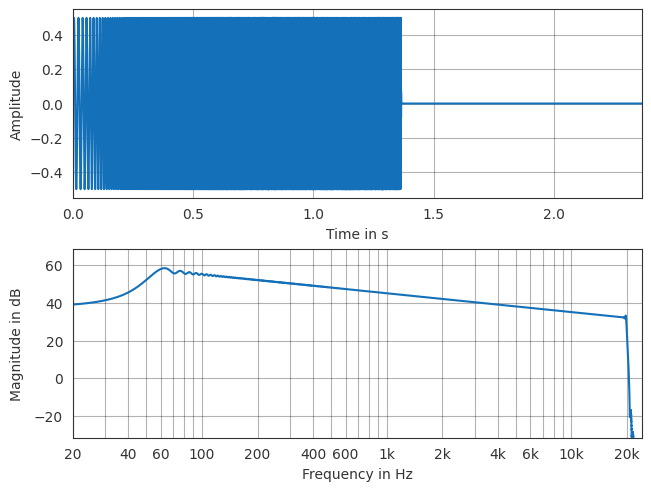

In [84]:
fs = 48e3
sweep = pf.signals.exponential_sweep_time(2**16, sampling_rate=fs, 
                                          amplitude=0.5,
                                          frequency_range=(50, 20e3))

# add one second of silence at the end
sweep = pf.dsp.pad_zeros(sweep, int(fs*1))

pf.plot.time_freq(sweep)
plt.show()


### Initialize Device

In [85]:
devices = sd.query_devices()
print(devices)

# Set device by entering D & samplerate
sd.default.device = 22
sd.default.samplerate = fs


   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
   1 Analog (5+6) (2- RME Fireface U, MME (2 in, 0 out)
   2 Analog (1+2) (2- RME Fireface U, MME (2 in, 0 out)
   3 Mikrofon (Realtek High Definiti, MME (2 in, 0 out)
   4 Analog (3+4) (2- RME Fireface U, MME (2 in, 0 out)
   5 Stereomix (Realtek High Definit, MME (2 in, 0 out)
   6 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
   7 Lautsprecher (2- RME Fireface U, MME (0 in, 2 out)
   8 Analog (5+6) (2- RME Fireface U, MME (0 in, 2 out)
   9 Analog (3+4) (2- RME Fireface U, MME (0 in, 2 out)
  10 Speakers/Headphones (Realtek Hi, MME (0 in, 2 out)
  11 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
  12 Analog (5+6) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  13 Analog (1+2) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  14 Mikrofon (Realtek High Definition Audio), Windows DirectSound (2 in, 0 out)
  15 Analog (3+4) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  16 Ster

In [11]:
for i in range(10):
    sd.play(sweep.time.T, fs, mapping=[1], blocking=True)


KeyboardInterrupt: 

In [ ]:
sd.stop()

### Reference Recording

<p>Connect output of the measuring device to input to capture system response
for compensation.</p>

In [ ]:
# ADAT begins at channel 15, mapping starts at id=1
reference = sd.playrec(sweep.time.T, channels=1, samplerate=fs,
                         input_mapping=[15], 
                         output_mapping=[1], 
                         blocking=True)

ref = pf.Signal(reference.squeeze(), fs)

# save reference signal as wav file
fp = r"Measurements/reference.wav"
pf.io.write_audio(ref, fp, overwrite=False)

### Recording with turntable

In [ ]:
# define azimuth angles
step = 3
azimuth = np.arange(-45, 46, step=step)

system_response = np.zeros((len(azimuth), 16, len(sweep.time)))

for i, az in enumerate(azimuth):
    print(f"Measuring at azimuth {az} deg")

    rec = sd.playrec(sweep.time.T, channels=16, samplerate=fs,
                     input_mapping=[15, 30],
                     output_mapping=[1])
    
    system_response[i] = rec
    input(print(f"Press 'Enter' to continue.\nNext measurement at {az+step}"
                " degree azimuth."))

In [ ]:
# save data to SOFA file
azi = np.tile(azimuth, (16, 1))
azi = azi.flatten(order='F')

### RAR IR Measurment

In [19]:
ema_16_rar = np.zeros((5, 16, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=np.arange(15, 31), 
                         output_mapping=[1], 
                         blocking=True).T
    
    ema_16_rar[i] = rec

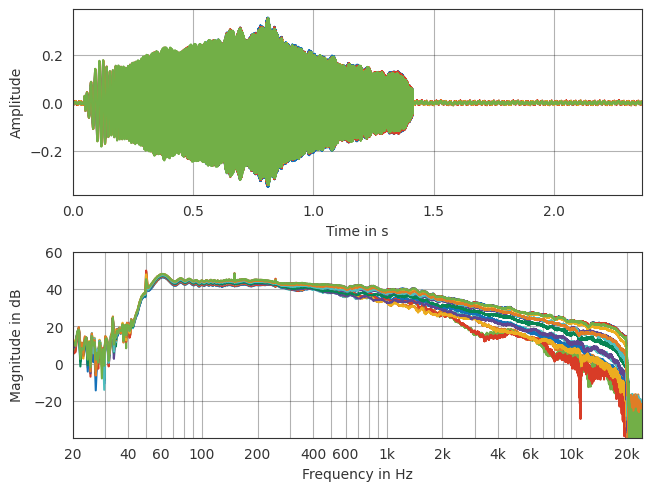

In [20]:
meas = pf.Signal(ema_16_rar, fs)
meas = pf.dsp.average(meas, caxis=0)

pf.plot.time_freq(meas, label='0')
plt.show()

In [21]:
pf.io.write_audio(meas, r"Measurements/25_01_21_ema_16_rar_50Hz_20kHz.wav")

### Reference RAR

In [53]:
ref_rar = np.zeros((5, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=[15], 
                         output_mapping=[1], 
                         blocking=True).T
    
    ref_rar[i] = rec

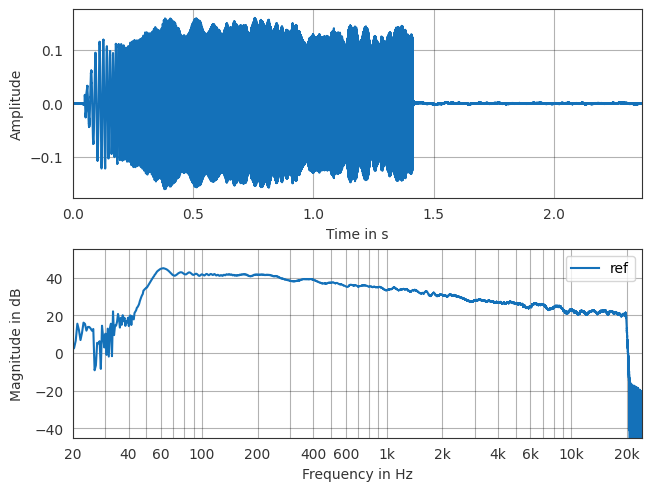

In [54]:
ref_rar_sig = pf.Signal(ref_rar, fs)
ref_rar_sig = pf.dsp.average(ref_rar_sig, caxis=0)

pf.plot.time_freq(ref_rar_sig, label='ref')
# pf.plot.time_freq(meas[0], label='ema')

plt.legend()
plt.show()  

In [55]:
pf.io.write_audio(ref_rar_sig, r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_reference.wav")

### Dummy head (clockwise rotation)

In [50]:
dummy_head = np.zeros((5, 2, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=[13, 14], 
                         output_mapping=[1], 
                         blocking=True).T
    
    dummy_head[i] = rec

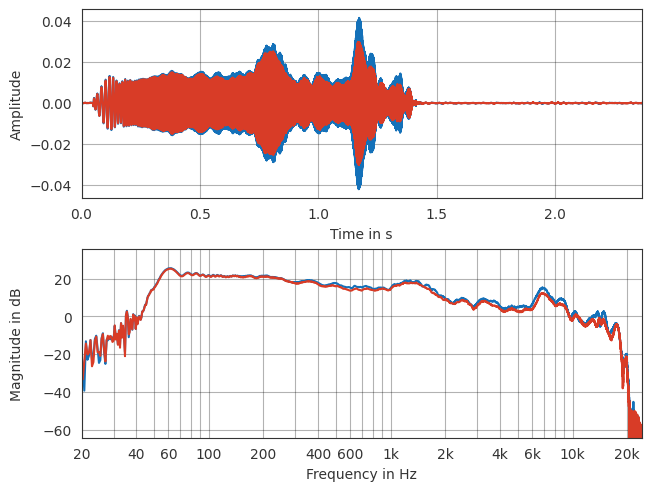

In [51]:
dummy_head_sig = pf.Signal(dummy_head, fs)
dummy_head_sig = pf.dsp.average(dummy_head_sig, caxis=0)

pf.plot.time_freq(dummy_head_sig, label='dummy_head')
plt.show()

In [52]:
pf.io.write_audio(dummy_head_sig, r"Measurements Rar/25_01_21_dummy_head_rar_50Hz_20kHz_180_degree.wav")

### Deconvolution

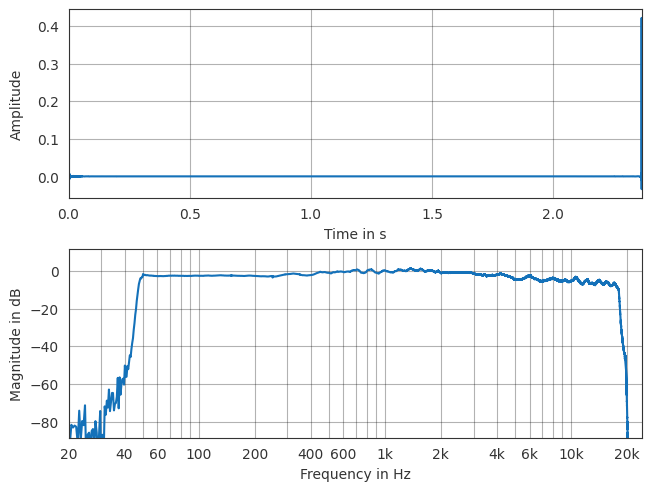

In [82]:
IR = pf.dsp.deconvolve(pf.dsp.normalize(meas)[0], pf.dsp.normalize(ref_rar_sig), freq_range=(50, 18e3))

pf.plot.time_freq(IR)
plt.show()

### Load Results

In [42]:
hrir_135 = pf.io.read_audio(r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_135_degree.wav")
hrir_90 = pf.io.read_audio(r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_90_degree.wav")

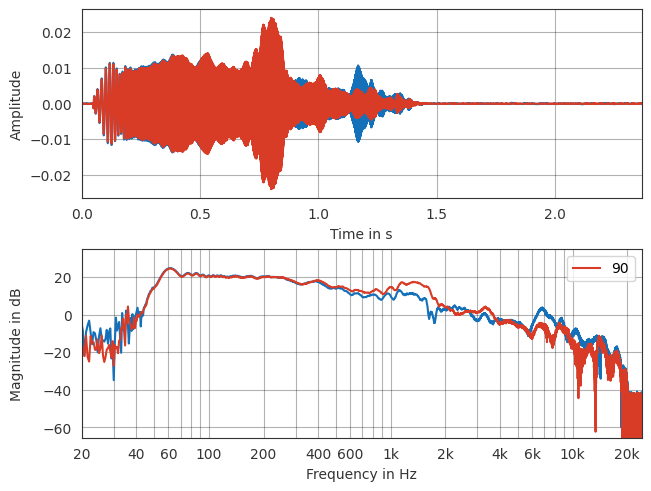

In [49]:
pf.plot.time_freq(hrir_135[1])
pf.plot.time_freq(hrir_90[1], label='90')
plt.legend()
plt.show()

### Recording of Anechoic Audio

<p> Listener Height: 1.20 <br>
Listener Distance: 1.45 <br>
Speaker Distance Within: 1.48 <br>
Speaker Height: 1.04

In [124]:
audio = pf.io.read_audio(r'signals/mov1_stereo.wav')
audio = pf.dsp.normalize(audio)

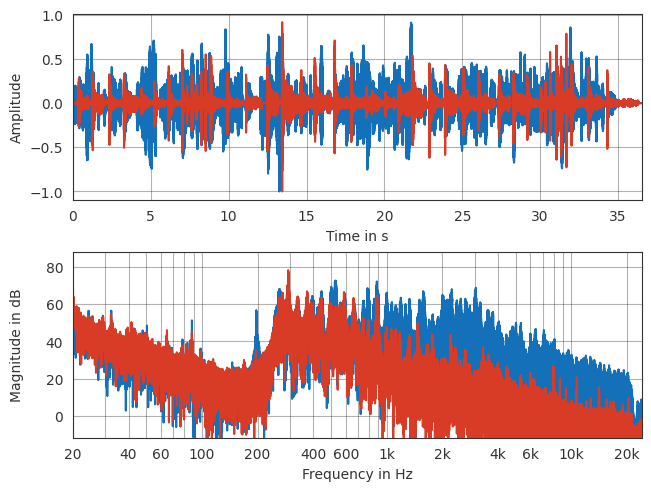

In [127]:
pf.plot.time_freq(audio)
plt.show()

In [130]:
ema_recording = sd.playrec(audio.time.T, input_mapping=np.arange(15, 31), output_mapping=[1, 2], blocking=True, samplerate=fs)

In [131]:
ema_recording.shape

(1752868, 16)

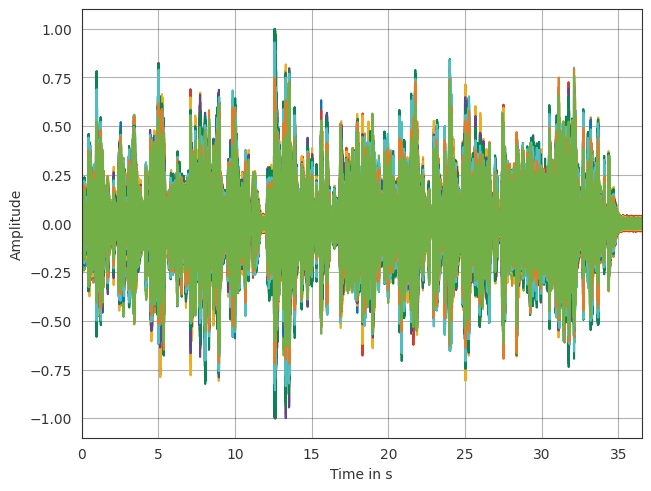

In [132]:
recording = pf.Signal(ema_recording.T, fs)
pf.io.write_audio(recording, r"Recording_Reverberant/ema16_2.wav")


pf.plot.time(recording)
plt.show()

In [110]:
test = sd.rec(int(48000*30), 48000, mapping=np.arange(15, 31), blocking=True)

In [111]:
sig = pf.Signal(test.T, 48000)
pf.io.write_audio(pf.dsp.normalize(sig, channel_handling='max'), r"Recording_Reverberant/test.wav")

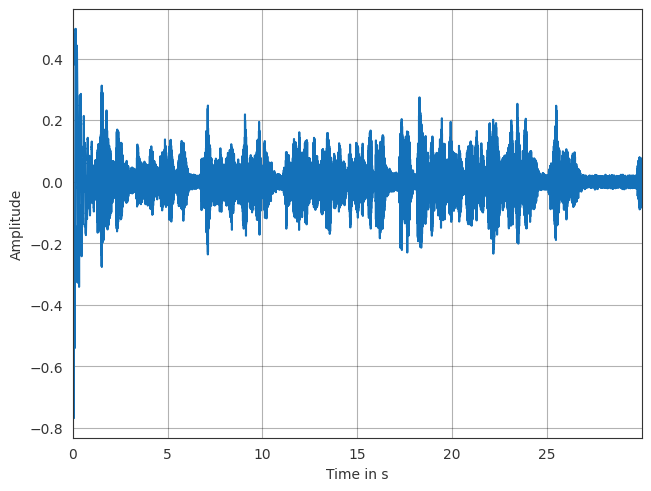

In [123]:
pf.plot.time(sig[5])
plt.show()